## Comparing the amplitude of the interface between two fluids with the analytical expression

This script compares amplitude data of the interface between two superimposed fluids with the analytical expression, given by eq. 22 from Prosperetti 1981 paper motion of two superimposed fluids.

In [173]:
#Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import erfc
from scipy.integrate import odeint
from scipy.integrate import quadrature
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
import time

#Use Latex and serif font
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


#Functions:
#1.Reads data from file and separates columns into relevant physical variables i.e. time, Amplitude
def read_extract(dat_file):
    df = pd.read_csv(dat_file, sep=' ')
    df.head()
    nb_col = len(df.columns)
    
    if (nb_col==2):
        t = df.iloc[:, 0].to_numpy()
        Amp = df.iloc[:, 1].to_numpy()
        A0 = Amp[0]
        return A0, t, Amp
    
    else :
        t = df.iloc[:, 0].to_numpy()
        AmpOcean = df.iloc[:, 1].to_numpy()
        AmpIce = df.iloc[:, 2].to_numpy()
        A0_Ocean = AmpOcean[0]
        A0_Ice = AmpIce[0]
        return A0_Ocean, A0_Ice, t, AmpOcean, AmpIce

#2.Calculates the slope for a given data point
def calculate_slope(x_pt, y_pt, i):
    print(i)
    if i < 0 or i >= len(x_pt):
        return None  
    if i == 0:
        slope = (y_pt[i+1] - y_pt[i]) / (x_pt[i+1] - x_pt[i])
    elif i <= len(x_pt) - 1:
        slope = (y_pt[i] - y_pt[i-1]) / (x_pt[i] - x_pt[i-1])
    else:
        slope = (y_pt[i+1] - y_pt[i-1]) / (x_pt[i+1] - x_pt[i-1])
    return slope

#Calculate Zis using cyclical permutation of zis 
def cycl_roots(z):
    Z = np.zeros(0)
    for z_i in z:
        mult = 1
        for z_j in z:
            if z_i != z_j:
                mult = mult*(z_j-z_i)
        Z = np.append(Z,mult)
    return Z


#Calculates Analytical expression for the Amplitude (Eq. 20 from Prosperetti)
def ampl(t,a0,u0,Ga,Beta,z,Z):
    b = 1-4*Beta
    Amp_p1 = a0 * (erfc(k2v*t)**0.5) * 32 * b * np.pi**3 / (64 * b * np.pi**3 + Ga)
    Amp_p2 = 0
    for i in range(4):
        Amp_p21 = (z[i]/Z[i]) * (2*np.pi*A_0/(z[i]**2-k2v)-U_0) 
        Amp_p22 = np.exp((z[i]**2-k2v)*t) * erfc(z[i]*t**0.5)
        Amp_p2 = Amp_p2 + (Amp_p21 * Amp_p22)
    return Amp_p1 + Amp_p2 

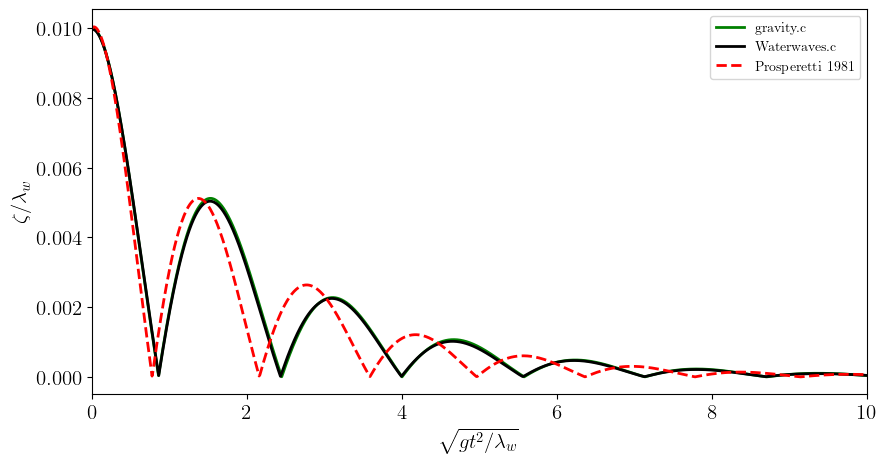

In [181]:
# Generates analytical expression of a(t) using Eq 20 and 21 from Prosperetti 1981

#Initializing variables 
p_u = 1
p_l = 0.1
Ga = 1e4
A_0 = 0.01
U_0 = -1e-5 #Taken from the estimation of a'(0)

#Calculating zi, Zi, non dimensional Amplitude
B = (p_u * p_l)/((p_u + p_l)**2)
k2v = 4 * (np.pi**2/np.sqrt(Ga))
p = np.poly1d([1, -4*B*k2v**0.5, 2*(1-6*B)*k2v, 4*(1-3*B)*k2v**1.5,(1-4*B)*k2v**2+(2*np.pi)])
z = p.roots 
Z = cycl_roots(z)

t_1981 = np.linspace(0, 10, 1000)
Amp_1981 = ampl(t_1981,A_0,U_0,Ga,B,z,Z)

#2. Extracts amplitude data from gravity.c and waterwaves.c
A0, t, Amp = read_extract('wave-256') #gravity.c
A0_w, t_w, Amp_w = read_extract('WavesWater_/amplitude.dat') #waterwaves.c


#Plot
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(t, Amp, 'g-', lw=2, label='gravity.c') 
ax.plot(t_w, abs(Amp_w), 'k', lw=2, label='Waterwaves.c')
ax.plot(t_1981, abs(Amp_1981), 'r--', lw=2, label='Prosperetti 1981')
ax.set_xlabel(r'$\sqrt{gt^2/\lambda_w}$', fontsize=15)
ax.set_ylabel(r'$\zeta/\lambda_w$', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlim([0., 10])
#ax.set_ylim([0., A0])
ax.legend()
plt.savefig("Interface_Analyticalcomparaison")
plt.show()